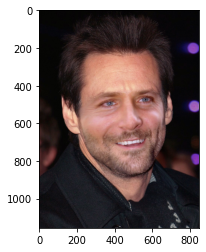

In [6]:
import cv2
import numpy as np
import dlib
import time
import matplotlib.pyplot as plt
import matplotlib.image as imgo


def extract_index_nparray(nparray):
    index = None
    for num in nparray[0]:
        index = num
        break
    return index


img = imgo.imread("/content/bradley_cooper.jpg")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mask = np.zeros_like(img_gray)
img2 = imgo.imread("/content/jim_carrey.jpg")
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)


detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("/content/shape_predictor_68_face_landmarks.dat")
height, width, channels = img2.shape
img2_new_face = np.zeros((height, width, channels), np.uint8)




# Face 1
faces = detector(img_gray)
for face in faces:
    landmarks = predictor(img_gray, face)
    landmarks_points = []
    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmarks_points.append((x, y))



    points = np.array(landmarks_points, np.int32)
    convexhull = cv2.convexHull(points)
    # cv2.polylines(img, [convexhull], True, (255, 0, 0), 3)
    cv2.fillConvexPoly(mask, convexhull, 255)

    face_image_1 = cv2.bitwise_and(img, img, mask=mask)

    # Delaunay triangulation
    rect = cv2.boundingRect(convexhull)
    subdiv = cv2.Subdiv2D(rect)
    subdiv.insert(landmarks_points)
    triangles = subdiv.getTriangleList()
    triangles = np.array(triangles, dtype=np.int32)

    indexes_triangles = []
    for t in triangles:
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])


        index_pt1 = np.where((points == pt1).all(axis=1))
        index_pt1 = extract_index_nparray(index_pt1)

        index_pt2 = np.where((points == pt2).all(axis=1))
        index_pt2 = extract_index_nparray(index_pt2)

        index_pt3 = np.where((points == pt3).all(axis=1))
        index_pt3 = extract_index_nparray(index_pt3)

        if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
            triangle = [index_pt1, index_pt2, index_pt3]
            indexes_triangles.append(triangle)



# Face 2
faces2 = detector(img2_gray)
for face in faces2:
    landmarks = predictor(img2_gray, face)
    landmarks_points2 = []
    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmarks_points2.append((x, y))


    points2 = np.array(landmarks_points2, np.int32)
    convexhull2 = cv2.convexHull(points2)

lines_space_mask = np.zeros_like(img_gray)
lines_space_new_face = np.zeros_like(img2)
# Triangulation of both faces
for triangle_index in indexes_triangles:
    # Triangulation of the first face
    tr1_pt1 = landmarks_points[triangle_index[0]]
    tr1_pt2 = landmarks_points[triangle_index[1]]
    tr1_pt3 = landmarks_points[triangle_index[2]]
    triangle1 = np.array([tr1_pt1, tr1_pt2, tr1_pt3], np.int32)


    rect1 = cv2.boundingRect(triangle1)
    (x, y, w, h) = rect1
    cropped_triangle = img[y: y + h, x: x + w]
    cropped_tr1_mask = np.zeros((h, w), np.uint8)


    points = np.array([[tr1_pt1[0] - x, tr1_pt1[1] - y],
                       [tr1_pt2[0] - x, tr1_pt2[1] - y],
                       [tr1_pt3[0] - x, tr1_pt3[1] - y]], np.int32)

    cv2.fillConvexPoly(cropped_tr1_mask, points, 255)

    # Lines space
    cv2.line(lines_space_mask, tr1_pt1, tr1_pt2, 255)
    cv2.line(lines_space_mask, tr1_pt2, tr1_pt3, 255)
    cv2.line(lines_space_mask, tr1_pt1, tr1_pt3, 255)
    lines_space = cv2.bitwise_and(img, img, mask=lines_space_mask)

    # Triangulation of second face
    tr2_pt1 = landmarks_points2[triangle_index[0]]
    tr2_pt2 = landmarks_points2[triangle_index[1]]
    tr2_pt3 = landmarks_points2[triangle_index[2]]
    triangle2 = np.array([tr2_pt1, tr2_pt2, tr2_pt3], np.int32)


    rect2 = cv2.boundingRect(triangle2)
    (x, y, w, h) = rect2

    cropped_tr2_mask = np.zeros((h, w), np.uint8)

    points2 = np.array([[tr2_pt1[0] - x, tr2_pt1[1] - y],
                        [tr2_pt2[0] - x, tr2_pt2[1] - y],
                        [tr2_pt3[0] - x, tr2_pt3[1] - y]], np.int32)

    cv2.fillConvexPoly(cropped_tr2_mask, points2, 255)

    # Warp triangles
    points = np.float32(points)
    points2 = np.float32(points2)
    M = cv2.getAffineTransform(points, points2)
    warped_triangle = cv2.warpAffine(cropped_triangle, M, (w, h))
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=cropped_tr2_mask)

    # Reconstructing destination face
    img2_new_face_rect_area = img2_new_face[y: y + h, x: x + w]
    img2_new_face_rect_area_gray = cv2.cvtColor(img2_new_face_rect_area, cv2.COLOR_BGR2GRAY)
    _, mask_triangles_designed = cv2.threshold(img2_new_face_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask_triangles_designed)

    img2_new_face_rect_area = cv2.add(img2_new_face_rect_area, warped_triangle)
    img2_new_face[y: y + h, x: x + w] = img2_new_face_rect_area



# Face swapped (putting 1st face into 2nd face)
img2_face_mask = np.zeros_like(img2_gray)
img2_head_mask = cv2.fillConvexPoly(img2_face_mask, convexhull2, 255)
img2_face_mask = cv2.bitwise_not(img2_head_mask)


img2_head_noface = cv2.bitwise_and(img2, img2, mask=img2_face_mask)
result = cv2.add(img2_head_noface, img2_new_face)

(x, y, w, h) = cv2.boundingRect(convexhull2)
center_face2 = (int((x + x + w) / 2), int((y + y + h) / 2))

seamlessclone = cv2.seamlessClone(result, img2, img2_head_mask, center_face2, cv2.NORMAL_CLONE)

plt.imshow( seamlessclone)
#cv2.waitKey(0)



#cv2.destroyAllWindows()


In [7]:
import cv2
import numpy as np
import dlib
import time
import matplotlib.pyplot as plt
import matplotlib.image as imgo


def extract_index_nparray(nparray):
    index = None
    for num in nparray[0]:
        index = num
        break
    return index


img = imgo.imread("/content/bradley_cooper.jpg")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mask = np.zeros_like(img_gray)

cap = cv2.VideoCapture(0)

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

indexes_triangles = []

# Face 1
faces = detector(img_gray)
for face in faces:
    landmarks = predictor(img_gray, face)
    landmarks_points = []
    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmarks_points.append((x, y))

        # cv2.circle(img, (x, y), 3, (0, 0, 255), -1)

    points = np.array(landmarks_points, np.int32)
    convexhull = cv2.convexHull(points)
    # cv2.polylines(img, [convexhull], True, (255, 0, 0), 3)
    cv2.fillConvexPoly(mask, convexhull, 255)

    face_image_1 = cv2.bitwise_and(img, img, mask=mask)

    # Delaunay triangulation
    rect = cv2.boundingRect(convexhull)
    subdiv = cv2.Subdiv2D(rect)
    subdiv.insert(landmarks_points)
    triangles = subdiv.getTriangleList()
    triangles = np.array(triangles, dtype=np.int32)

    indexes_triangles = []
    for t in triangles:
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])

        index_pt1 = np.where((points == pt1).all(axis=1))
        index_pt1 = extract_index_nparray(index_pt1)

        index_pt2 = np.where((points == pt2).all(axis=1))
        index_pt2 = extract_index_nparray(index_pt2)

        index_pt3 = np.where((points == pt3).all(axis=1))
        index_pt3 = extract_index_nparray(index_pt3)

        if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
            triangle = [index_pt1, index_pt2, index_pt3]
            indexes_triangles.append(triangle)


while True:
    _, img2 = cap.read()
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    img2_new_face = np.zeros_like(img2)

    # Face 2
    faces2 = detector(img2_gray)
    for face in faces2:
        landmarks = predictor(img2_gray, face)
        landmarks_points2 = []
        for n in range(0, 68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            landmarks_points2.append((x, y))

        # cv2.circle(img2, (x, y), 3, (0, 255, 0), -1)
        points2 = np.array(landmarks_points2, np.int32)
        convexhull2 = cv2.convexHull(points2)

    lines_space_mask = np.zeros_like(img_gray)
    lines_space_new_face = np.zeros_like(img2)

    # Triangulation of both faces
    for triangle_index in indexes_triangles:
        # Triangulation of the first face
        tr1_pt1 = landmarks_points[triangle_index[0]]
        tr1_pt2 = landmarks_points[triangle_index[1]]
        tr1_pt3 = landmarks_points[triangle_index[2]]
        triangle1 = np.array([tr1_pt1, tr1_pt2, tr1_pt3], np.int32)

        rect1 = cv2.boundingRect(triangle1)
        (x, y, w, h) = rect1
        cropped_triangle = img[y: y + h, x: x + w]
        cropped_tr1_mask = np.zeros((h, w), np.uint8)

        points = np.array([[tr1_pt1[0] - x, tr1_pt1[1] - y],
                           [tr1_pt2[0] - x, tr1_pt2[1] - y],
                           [tr1_pt3[0] - x, tr1_pt3[1] - y]], np.int32)

        cv2.fillConvexPoly(cropped_tr1_mask, points, 255)

        # Triangulation of second face
        tr2_pt1 = landmarks_points2[triangle_index[0]]
        tr2_pt2 = landmarks_points2[triangle_index[1]]
        tr2_pt3 = landmarks_points2[triangle_index[2]]
        triangle2 = np.array([tr2_pt1, tr2_pt2, tr2_pt3], np.int32)

        rect2 = cv2.boundingRect(triangle2)
        (x, y, w, h) = rect2

        cropped_tr2_mask = np.zeros((h, w), np.uint8)

        points2 = np.array([[tr2_pt1[0] - x, tr2_pt1[1] - y],
                            [tr2_pt2[0] - x, tr2_pt2[1] - y],
                            [tr2_pt3[0] - x, tr2_pt3[1] - y]], np.int32)

        cv2.fillConvexPoly(cropped_tr2_mask, points2, 255)



        # Warp triangles
        points = np.float32(points)
        points2 = np.float32(points2)
        M = cv2.getAffineTransform(points, points2)
        warped_triangle = cv2.warpAffine(cropped_triangle, M, (w, h))
        warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=cropped_tr2_mask)


        # Reconstructing destination face
        img2_new_face_rect_area = img2_new_face[y: y + h, x: x + w]
        img2_new_face_rect_area_gray = cv2.cvtColor(img2_new_face_rect_area, cv2.COLOR_BGR2GRAY)
        _, mask_triangles_designed = cv2.threshold(img2_new_face_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
        warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask_triangles_designed)

        img2_new_face_rect_area = cv2.add(img2_new_face_rect_area, warped_triangle)
        img2_new_face[y: y + h, x: x + w] = img2_new_face_rect_area


    # Face swapped (putting 1st face into 2nd face)
    img2_face_mask = np.zeros_like(img2_gray)
    img2_head_mask = cv2.fillConvexPoly(img2_face_mask, convexhull2, 255)
    img2_face_mask = cv2.bitwise_not(img2_head_mask)


    img2_head_noface = cv2.bitwise_and(img2, img2, mask=img2_face_mask)
    result = cv2.add(img2_head_noface, img2_new_face)

    (x, y, w, h) = cv2.boundingRect(convexhull2)
    center_face2 = (int((x + x + w) / 2), int((y + y + h) / 2))

    seamlessclone = cv2.seamlessClone(result, img2, img2_head_mask, center_face2, cv2.MIXED_CLONE)

    plt.imshow(img2)
    plt.imshow(seamlessclone)
    plt.imshow(result)

    key = cv2.waitKey(1)
    if key == 27:
        break

cap.release()
cv2.destroyAllWindows()


error: ignored

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [13]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes


# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

import cv2
import numpy as np
import dlib
import time
import matplotlib.pyplot as plt
import matplotlib.image as imgo


def extract_index_nparray(nparray):
    index = None
    for num in nparray[0]:
        index = num
        break
    return index


img = imgo.imread("/content/bradley_cooper.jpg")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mask = np.zeros_like(img_gray)

cap = cv2.VideoCapture(0)

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

indexes_triangles = []

# Face 1
faces = detector(img_gray)
for face in faces:
    landmarks = predictor(img_gray, face)
    landmarks_points = []
    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmarks_points.append((x, y))

        # cv2.circle(img, (x, y), 3, (0, 0, 255), -1)

    points = np.array(landmarks_points, np.int32)
    convexhull = cv2.convexHull(points)
    # cv2.polylines(img, [convexhull], True, (255, 0, 0), 3)
    cv2.fillConvexPoly(mask, convexhull, 255)

    face_image_1 = cv2.bitwise_and(img, img, mask=mask)

    # Delaunay triangulation
    rect = cv2.boundingRect(convexhull)
    subdiv = cv2.Subdiv2D(rect)
    subdiv.insert(landmarks_points)
    triangles = subdiv.getTriangleList()
    triangles = np.array(triangles, dtype=np.int32)

    indexes_triangles = []
    for t in triangles:
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])

        index_pt1 = np.where((points == pt1).all(axis=1))
        index_pt1 = extract_index_nparray(index_pt1)

        index_pt2 = np.where((points == pt2).all(axis=1))
        index_pt2 = extract_index_nparray(index_pt2)

        index_pt3 = np.where((points == pt3).all(axis=1))
        index_pt3 = extract_index_nparray(index_pt3)

        if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
            triangle = [index_pt1, index_pt2, index_pt3]
            indexes_triangles.append(triangle)
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0             

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break
    img2 = js_to_image(js_reply["img"])
    #_, img2 = cap.read()
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    img2_new_face = np.zeros_like(img2)

    # Face 2
    faces2 = detector(img2_gray)
    for face in faces2:
        landmarks = predictor(img2_gray, face)
        landmarks_points2 = []
        for n in range(0, 68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            landmarks_points2.append((x, y))

        cv2.circle(img2, (x, y), 3, (0, 255, 0), -1)
        points2 = np.array(landmarks_points2, np.int32)
        convexhull2 = cv2.convexHull(points2)

    lines_space_mask = np.zeros_like(img_gray)
    lines_space_new_face = np.zeros_like(img2)

    # Triangulation of both faces
    for triangle_index in indexes_triangles:
        # Triangulation of the first face
        tr1_pt1 = landmarks_points[triangle_index[0]]
        tr1_pt2 = landmarks_points[triangle_index[1]]
        tr1_pt3 = landmarks_points[triangle_index[2]]
        triangle1 = np.array([tr1_pt1, tr1_pt2, tr1_pt3], np.int32)

        rect1 = cv2.boundingRect(triangle1)
        (x, y, w, h) = rect1
        cropped_triangle = img[y: y + h, x: x + w]
        cropped_tr1_mask = np.zeros((h, w), np.uint8)

        points = np.array([[tr1_pt1[0] - x, tr1_pt1[1] - y],
                           [tr1_pt2[0] - x, tr1_pt2[1] - y],
                           [tr1_pt3[0] - x, tr1_pt3[1] - y]], np.int32)

        cv2.fillConvexPoly(cropped_tr1_mask, points, 255)

        # Triangulation of second face
        tr2_pt1 = landmarks_points2[triangle_index[0]]
        tr2_pt2 = landmarks_points2[triangle_index[1]]
        tr2_pt3 = landmarks_points2[triangle_index[2]]
        triangle2 = np.array([tr2_pt1, tr2_pt2, tr2_pt3], np.int32)

        rect2 = cv2.boundingRect(triangle2)
        (x, y, w, h) = rect2

        cropped_tr2_mask = np.zeros((h, w), np.uint8)

        points2 = np.array([[tr2_pt1[0] - x, tr2_pt1[1] - y],
                            [tr2_pt2[0] - x, tr2_pt2[1] - y],
                            [tr2_pt3[0] - x, tr2_pt3[1] - y]], np.int32)

        cv2.fillConvexPoly(cropped_tr2_mask, points2, 255)



        # Warp triangles
        points = np.float32(points)
        points2 = np.float32(points2)
        M = cv2.getAffineTransform(points, points2)
        warped_triangle = cv2.warpAffine(cropped_triangle, M, (w, h))
        warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=cropped_tr2_mask)


        # Reconstructing destination face
        img2_new_face_rect_area = img2_new_face[y: y + h, x: x + w]
        img2_new_face_rect_area_gray = cv2.cvtColor(img2_new_face, cv2.COLOR_BGR2GRAY)
        _, mask_triangles_designed = cv2.threshold(img2_new_face_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
        warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask_triangles_designed)

        img2_new_face_rect_area = cv2.add(img2_new_face_rect_area, warped_triangle)
        img2_new_face[y: y + h, x: x + w] = img2_new_face_rect_area


    # Face swapped (putting 1st face into 2nd face)
    img2_face_mask = np.zeros_like(img2_gray)
    img2_head_mask = cv2.fillConvexPoly(img2_face_mask, convexhull2, 255)
    img2_face_mask = cv2.bitwise_not(img2_head_mask)


    img2_head_noface = cv2.bitwise_and(img2, img2, mask=img2_face_mask)
    result = cv2.add(img2_head_noface, img2_new_face)

    (x, y, w, h) = cv2.boundingRect(convexhull2)
    center_face2 = (int((x + x + w) / 2), int((y + y + h) / 2))

    seamlessclone = cv2.seamlessClone(result, img2, img2_head_mask, center_face2, cv2.MIXED_CLONE)

    plt.imshow(img2)
    plt.imshow(seamlessclone)
    plt.imshow(result)

    key = cv2.waitKey(1)
    if key == 27:
        break

cap.release()
cv2.destroyAllWindows()


<IPython.core.display.Javascript object>

error: ignored

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))